In [31]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


pd.set_option('display.max_columns', None)

DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets/LoL_esports')
LEAGUES = ['worlds', 'msi', 'lck', 'lpl', 'lec', 'lcs']

In [32]:
def feature_engineering(df):
    df['KD'] = df['TeamKills'] / df['OpponentKills']
    df.loc[df['KD'] == np.inf, 'KD'] = df.loc[df['KD'] == np.inf, 'TeamKills']
    df['CKPM'] = df[['TeamKills', 'OpponentKills']].sum(axis=1) / df['Gamelength Number']
    df['KPM'] = df['TeamKills'] / df['Gamelength Number']
    df['GPM'] = df['TeamGold'] / df['Gamelength Number']
    df['GDPM'] = (df['TeamGold'] - df['OpponentGold']) / df['Gamelength Number']
    df['GDP'] = (df['TeamGold'] - df['OpponentGold']) / df[['TeamGold', 'OpponentGold']].mean(axis=1)
    df['KDPM'] = (df['TeamKills'] - df['OpponentKills']) / df['Gamelength Number']
    df['Outlier'] = df['KPM'] * df['GDPM']
    df['Outlier2'] = df['KDPM'] * df['GDPM']
    return df

def extract_teams(df):
    grouped = df.groupby(['OverviewPage', 'Team'])
    teams = pd.DataFrame()
    teams['Win'] = grouped['Win'].sum()
    teams['Loss'] = grouped['Loss'].sum()
    teams['Gold'] = grouped['TeamGold'].mean()
    teams['Kills'] = grouped['TeamKills'].mean()
    teams['Deaths'] = grouped['OpponentKills'].mean()
    teams['Gamelength Number'] = grouped['Gamelength Number'].mean()
    teams['Win Gamelength Number'] = \
        grouped[['Win', 'Gamelength Number']].apply(
            lambda x: (x['Win'] * x['Gamelength Number']).sum()
        ) / teams['Win']
    teams['Loss Gamelength Number'] = \
        grouped[['Loss', 'Gamelength Number']].apply(
            lambda x: (x['Loss'] * x['Gamelength Number']).sum()
        ) / teams['Loss']
    teams.loc[teams['Win'] == 0, 'Win Gamelength Number'] = -1
    teams.loc[teams['Loss'] == 0, 'Loss Gamelength Number'] = -1
    teams['Games'] = grouped['Win'].count()
    teams['WinRate'] = teams['Win'] / teams['Games']
    teams['KD'] = grouped['KD'].mean()
    teams['CKPM'] = grouped['CKPM'].mean()
    teams['KPM'] = grouped['KPM'].mean()
    teams['GPM'] = grouped['GPM'].mean()
    teams['GDPM'] = grouped['GDPM'].mean()
    teams['GDP'] = grouped['GDP'].mean()
    teams['KDPM'] = grouped['KDPM'].mean()
    teams['Outlier'] = grouped['Outlier'].mean()
    teams['Outlier2'] = grouped['Outlier2'].mean()

    columns = [
        'Games', 'Win', 'Loss', 'WinRate', 'Gamelength Number',
        'Win Gamelength Number', 'Loss Gamelength Number', 'Gold', 'Kills',
        'Deaths', 'KD', 'CKPM', 'KPM', 'GPM', 'GDPM', 'GDP', 'KDPM',
        'Outlier', 'Outlier2'
    ]
    return teams[columns]


In [33]:
games = pd.read_csv(os.path.join(DATA_PATH, 'major_matches.csv'))
winners = pd.read_csv(os.path.join(DATA_PATH, 'major_matches_winners.csv'))

games.shape, winners.shape

((33742, 28), (102, 2))

In [34]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33742 entries, 0 to 33741
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OverviewPage        33742 non-null  object 
 1   Team                33742 non-null  object 
 2   Opponent            33742 non-null  object 
 3   Win                 33742 non-null  int64  
 4   Loss                33742 non-null  int64  
 5   DateTime UTC        33742 non-null  object 
 6   Gamelength          33736 non-null  object 
 7   Gamelength Number   33736 non-null  float64
 8   TeamBans            33742 non-null  object 
 9   OpponentBans        33742 non-null  object 
 10  TeamPicks           33742 non-null  object 
 11  OpponentPicks       33742 non-null  object 
 12  TeamPlayers         33742 non-null  object 
 13  OpponentPlayers     33742 non-null  object 
 14  TeamDragons         29692 non-null  float64
 15  OpponentDragons     29692 non-null  float64
 16  Team

In [35]:
games = feature_engineering(games)
games

,OverviewPage,Team,Opponent,Win,Loss,DateTime UTC,Gamelength,Gamelength Number,TeamBans,OpponentBans,TeamPicks,OpponentPicks,TeamPlayers,OpponentPlayers,TeamDragons,OpponentDragons,TeamBarons,OpponentBarons,TeamTowers,OpponentTowers,TeamGold,OpponentGold,TeamKills,OpponentKills,TeamRiftHeralds,OpponentHeralds,TeamInhibitors,OpponentInhibitors,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2
0,Season 1 World Championship,against All authority,Epik Gamer,0,1,2011-06-18 08:30:00,45:09,45.150000,"Akali,Vladimir,Nunu","Rumble,Nidalee,Twisted Fate","Irelia,Amumu,Karthus,Miss Fortune,Soraka","Singed,Warwick,Annie,Vayne,Janna","sOAZ,Linak,MoMa,YellOwStaR,Kujaa","Dyrus,Dan Dinh,Salce,Westrice,Doublelift",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Season 1 World Championship,Epik Gamer,against All authority,1,0,2011-06-18 08:30:00,45:09,45.150000,"Rumble,Nidalee,Twisted Fate","Akali,Vladimir,Nunu","Singed,Warwick,Annie,Vayne,Janna","Irelia,Amumu,Karthus,Miss Fortune,Soraka","Dyrus,Dan Dinh,Salce,Westrice,Doublelift","sOAZ,Linak,MoMa,YellOwStaR,Kujaa",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Season 1 World Championship,against All authority,Fnatic,1,0,2011-06-18 11:00:00,41:18,41.300000,"Alistar,Rumble,Twisted Fate","Irelia,Karthus,Nidalee","Gragas,Nunu,Anivia,Ashe,Sona","Vladimir,Amumu,Brand,Miss Fortune,Taric","sOAZ,Linak,MoMa,YellOwStaR,Kujaa","wewillfailer,Cyanide,Shushei,Lamia,Mellisan",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Season 1 World Championship,Fnatic,against All authority,0,1,2011-06-18 11:00:00,41:18,41.300000,"Irelia,Karthus,Nidalee","Alistar,Rumble,Twisted Fate","Vladimir,Amumu,Brand,Miss Fortune,Taric","Gragas,Nunu,Anivia,Ashe,Sona","wewillfailer,Cyanide,Shushei,Lamia,Mellisan","sOAZ,Linak,MoMa,YellOwStaR,Kujaa",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Season 1 World Championship,against All authority,Fnatic,0,1,2011-06-20 22:00:00,43:57,43.950000,"Alistar,Gragas,Anivia","Rumble,Nunu,Amumu","Malzahar,Jarvan IV,Irelia,Corki,Janna","Brand,Warwick,Karthus,Ashe,Sona","MoMa,Linak,sOAZ,YellOwStaR,Kujaa","Shushei,Cyanide,xPeke,Lamia,Mellisan",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33737,LEC/2022 Season/Summer,G2 Esports,Rogue (European Team),0,1,2022-09-11 17:17:00,29:09,29.150000,"Lucian,Renekton,Kalista,Caitlyn,Draven","Sylas,Senna,Yuumi,LeBlanc,Akali","Fiora,Trundle,Ahri,Zeri,Soraka","Aatrox,Jarvan IV,Azir,Sivir,Lulu","BrokenBlade,Jankos,caPs,Flakked,Targamas","Odoamne,Malrang,Larssen,Comp,Trymbi",1.0,3.0,0.0,1.0,3.0,10.0,47671.0,57510.0,3.0,12.0,0.0,2.0,0.0,2.0,0.250000,0.514580,0.102916,1635.368782,-337.530017,-0.187087,-0.308748,-34.737223,104.211669
33738,LEC/2022 Season/Summer,Rogue (European Team),MAD Lions,0,1,2022-08-26 16:13:00,38:03,38.050000,"Draven,Lulu,Gwen,Wukong,Vi","Azir,Poppy,Corki,Sivir,Ezreal","Renekton,Jarvan IV,Sylas,Zeri,Yuumi","Ornn,Trundle,Taliyah,Lucian,Nami","Odoamne,Malrang,Larssen,Comp,Trymbi","Armut,Elyoya,Nisqy,UNF0RGIVEN,Kaiser",1.0,4.0,0.0,1.0,4.0,9.0,62217.0,70311.0,11.0,26.0,2.0,0.0,0.0,1.0,0.423077,0.972405,0.289093,1635.137976,-212.720105,-0.122148,-0.394218,-61.495957,83.858123
33739,LEC/2022 Season/Summer,MAD Lions,Rogue (European Team),1,0,2022-08-26 16:13:00,38:03,38.050000,"Azir,Poppy,Corki,Sivir,Ezreal","Draven,Lulu,Gwen,Wukong,Vi","Ornn,Trundle,Taliyah,Lucian,Nami","Renekton,Jarvan IV,Sylas,Zeri,Yuumi","Armut,Elyoya,Nisqy,UNF0RGIVEN,Kaiser","Odoamne,Malrang,Larssen,Comp,Trymbi",4.0,1.0,1.0,0.0,9.0,4.0,70311.0,62217.0,26.0,11.0,0.0,2.0,1.0,0.0,2.363636,0.972405,0.683311,1847.858081,212.720105,0.122148,0.394218,145.354080,83.858123
33740,LEC/2022 Seaso

In [36]:
teams = extract_teams(games)
teams

Games  Win  Loss   WinRate  \
OverviewPage                   Team                                        
2014 Season World Championship Alliance           6    3     3  0.500000   
                               Cloud9            11    5     6  0.454545   
                               Dark Passage       6    0     6  0.000000   
                               EDward Gaming     12    6     6  0.500000   
                               Fnatic             6    2     4  0.333333   
...                                             ...  ...   ...       ...   
Season 3 World Championship    Royal Club         9    5     4  0.555556   
                               SK Telecom T1     18   15     3  0.833333   
                               Samsung Ozone      9    5     4  0.555556   
                               TSM                8    2     6  0.250000   
                               Team Vulcun        8    3     5  0.375000   

                                              Gamelength Number  \
OverviewPage                   Team                               
2014 Season World Championship Alliance               38.944444   
                               Cloud9                 36.703030   
                               Dark Passage           29.963889   
                               EDward Gaming          36.202778   
                               Fnatic                 44.719444   
...                                                         ...   
Season 3 World Championship    Royal Club             32.066667   
                               SK Telecom T1          31.558333   
                               Samsung Ozone          31.801852   
                               TSM                    35.831250   
                               Team Vulcun            30.447917   

                                              Win Gamelength Number  \
OverviewPage                   Team                                   
2014 Season World Championship Alliance                   37.355556   
                               Cloud9                     38.346667   
                               Dark Passage               -1.000000   
                               EDward Gaming              33.747222   
                               Fnatic                     40.033333   
...                                                             ...   
Season 3 World Championship    Royal Club                 33.326667   
                               SK Telecom T1              29.431111   
                               Samsung Ozone              30.430000   
                               TSM                        33.758333   
                               Team Vulcun                30.344444   

                                              Loss Gamelength Number  \
OverviewPage                   Team                                    
2014 Season World Championship Alliance                    40.533333   
                               Cloud9                      35.333333   
                               Dark Passage                29.963889   
                               EDward Gaming               38.658333   
                               Fnatic                      47.062500   
...                                                              ...   
Season 3 World Championship    Royal Club                  30.491667   
                               SK Telecom T1               42.194444   
                               Samsung Ozone               33.516667   
                               TSM                         36.522222   
                               Team Vulcun                 30.510000   

                                                      Gold      Kills  \
OverviewPage                   Team                                     
2014 Season World Championship Alliance       62333.333333  12.833333   
                               Cloud9         59309.090909  12.909091   
                               D

In [37]:
teams['Winner'] = 0
teams.loc[winners.apply(tuple, axis=1), 'Winner'] = 1
teams = teams.reset_index()
teams

,OverviewPage,Team,Games,Win,Loss,WinRate,Gamelength Number,Win Gamelength Number,Loss Gamelength Number,Gold,Kills,Deaths,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2,Winner
0,2014 Season World Championship,Alliance,6,3,3,0.500000,38.944444,37.355556,40.533333,62333.333333,12.833333,9.000000,3.531632,0.565349,0.333852,1602.455525,54.171227,0.034451,0.102356,43.820805,75.025131,0
1,2014 Season World Championship,Cloud9,11,5,6,0.454545,36.703030,38.346667,35.333333,59309.090909,12.909091,15.909091,1.647403,0.799993,0.359875,1619.407814,-43.437182,-0.017109,-0.080243,26.296809,153.886901,0
2,2014 Season World Championship,Dark Passage,6,0,6,0.000000,29.963889,-1.000000,29.963889,38266.666667,3.333333,20.666667,0.157257,0.823437,0.105509,1256.519169,-655.515401,-0.415561,-0.612419,-67.864840,416.682537,0
3,2014 Season World Championship,EDward Gaming,12,6,6,0.500000,36.202778,33.747222,38.658333,60608.333333,16.250000,14.083333,1.982591,0.857099,0.469209,1689.679321,115.783175,0.070883,0.081319,163.476252,184.804045,0
4,2014 Season World Championship,Fnatic,6,2,4,0.333333,44.719444,40.033333,47.062500,68766.666667,12.833333,13.833333,1.340316,0.599678,0.296168,1548.274383,-44.909069,-0.034210,-0.007343,74.422999,125.156669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,Season 3 World Championship,Royal Club,9,5,4,0.555556,32.066667,33.326667,30.491667,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1201,Season 3 World Championship,SK Telecom T1,18,15,3,0.833333,31.558333,29.431111,42.194444,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1202,Season 3 World Championship,Samsung Ozone,9,5,4,0.555556,31.801852,30.430000,33.516667,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1203,Season 3 World Championship,TSM,8,2,6,0.250000,35.831250,33.758333,36.522222,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [38]:
teams = teams.loc[teams[['Gold', 'Kills', 'Deaths']].dropna().index]
teams

,OverviewPage,Team,Games,Win,Loss,WinRate,Gamelength Number,Win Gamelength Number,Loss Gamelength Number,Gold,Kills,Deaths,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2,Winner
0,2014 Season World Championship,Alliance,6,3,3,0.500000,38.944444,37.355556,40.533333,62333.333333,12.833333,9.000000,3.531632,0.565349,0.333852,1602.455525,54.171227,0.034451,0.102356,43.820805,75.025131,0
1,2014 Season World Championship,Cloud9,11,5,6,0.454545,36.703030,38.346667,35.333333,59309.090909,12.909091,15.909091,1.647403,0.799993,0.359875,1619.407814,-43.437182,-0.017109,-0.080243,26.296809,153.886901,0
2,2014 Season World Championship,Dark Passage,6,0,6,0.000000,29.963889,-1.000000,29.963889,38266.666667,3.333333,20.666667,0.157257,0.823437,0.105509,1256.519169,-655.515401,-0.415561,-0.612419,-67.864840,416.682537,0
3,2014 Season World Championship,EDward Gaming,12,6,6,0.500000,36.202778,33.747222,38.658333,60608.333333,16.250000,14.083333,1.982591,0.857099,0.469209,1689.679321,115.783175,0.070883,0.081319,163.476252,184.804045,0
4,2014 Season World Championship,Fnatic,6,2,4,0.333333,44.719444,40.033333,47.062500,68766.666667,12.833333,13.833333,1.340316,0.599678,0.296168,1548.274383,-44.909069,-0.034210,-0.007343,74.422999,125.156669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,NA LCS/Season 3/Summer,TSM,35,18,17,0.514286,35.750952,34.239815,37.350980,54826.200000,15.142857,16.742857,1.430727,0.891137,0.428689,1537.937221,29.524790,0.021149,-0.033759,70.791362,141.594889,0
1167,NA LCS/Season 3/Summer,Team Coast,28,9,19,0.321429,36.900000,40.262963,35.307018,52060.607143,11.964286,14.750000,1.127052,0.728246,0.318188,1400.774095,-180.567467,-0.120603,-0.091869,-4.181762,129.192729,0
1168,NA LCS/Season 3/Summer,Team Curse,33,14,19,0.424242,37.522727,38.241667,36.992982,55834.032258,14.151515,14.515152,1.949503,0.769945,0.376247,1492.109150,-39.304847,-0.025807,-0.017451,47.141240,117.797481,0
1169,NA LCS/Season 3/Summer,Team Vulcun,32,22,10,0.687500,37.619271,36.798485,39.425000,60645.843750,18.218750,12.937500,1.875107,0.835251,0.492964,1619.406864,182.997621,0.117272,0.150677,151.405182,129.636736,0


In [39]:
columns = [
    'Games', 'WinRate', 'Gamelength Number', 'Win Gamelength Number',
    'Loss Gamelength Number', 'KD', 'CKPM', 'KPM', 'GPM', 'GDPM',
    'GDP', 'KDPM', 'Outlier', 'Outlier2'
]
X = teams[columns]
y = teams['Winner']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, stratify=y, random_state=0
)

X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((777, 14), (777,), (259, 14), (259,))

In [40]:
fold = RepeatedStratifiedKFold(random_state=0)

In [41]:
model = RandomForestClassifier(random_state=0)
scores = cross_val_score(model, X_trainval, y_trainval, scoring='roc_auc', cv=fold, n_jobs=-1)
scores.mean()

0.9574397475963253

In [42]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=0))])
scores = cross_val_score(pipe, X_trainval, y_trainval, cv=fold, scoring='roc_auc', n_jobs=-1)
scores.mean()

0.9619446850222997

In [43]:
model = GradientBoostingClassifier(random_state=0)
scores = cross_val_score(model, X_trainval, y_trainval, scoring='roc_auc', cv=fold, n_jobs=-1)
scores.mean()

0.9618842240568343

In [44]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}
grid_search = GridSearchCV(pipe, param_grid, cv=fold, return_train_score=True, n_jobs=-1, scoring='roc_auc')

In [45]:
grid_search.fit(X_trainval, y_trainval)

c:\Users\posky\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__solver': ['lbfgs', 'liblinear', 'sag',
                                           'saga']},
             return_train_score=True, scoring='roc_auc')

In [46]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 10, 'model__solver': 'sag'}
0.96246661090383


In [47]:
results = pd.DataFrame(grid_search.cv_results_)

<AxesSubplot:>

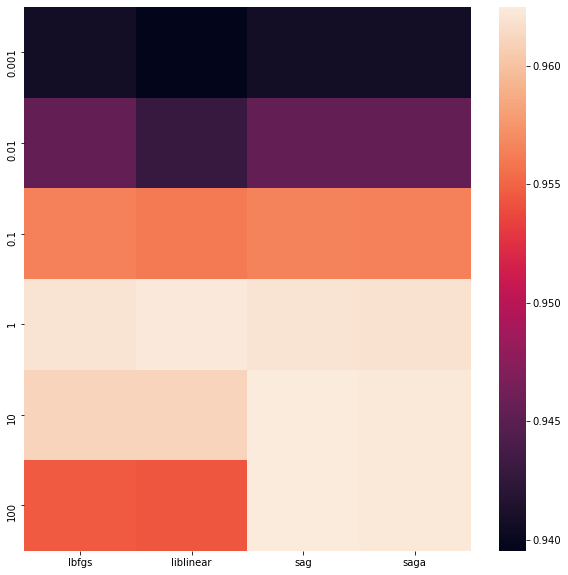

In [48]:
scores = np.array(results.mean_test_score).reshape(6, 4)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    scores,
    xticklabels=['lbfgs', 'liblinear', 'sag', 'saga'],
    yticklabels=[0.001, 0.01, 0.1, 1, 10, 100]
)

In [49]:
logreg = LogisticRegression(C=10, solver='sag', random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', logreg)])
pipe.fit(X_trainval, y_trainval)
pipe.score(X_trainval, y_trainval)

c:\Users\posky\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.9523809523809523

In [50]:
pipe.score(X_test, y_test)

0.9420849420849421

In [51]:
feature_importance = pd.DataFrame(data=np.abs(pipe['logreg'].coef_), columns=columns)
feature_importance

,Games,WinRate,Gamelength Number,Win Gamelength Number,Loss Gamelength Number,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2
0,0.368754,4.023328,0.066706,0.668969,0.482947,0.291314,0.1901,0.664302,0.453747,0.791304,0.77165,0.206792,0.838614,0.052222


Text(0.5, 1.0, 'Feature Importance')

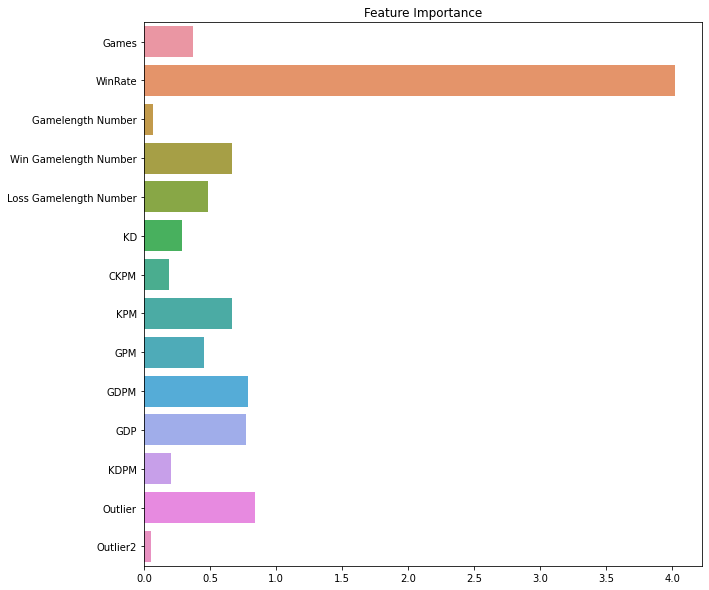

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=feature_importance.values.reshape(-1), y=feature_importance.columns)
plt.title('Feature Importance')

In [53]:
current_games = pd.read_csv(os.path.join(DATA_PATH, '2022_worlds_matches.csv'))
current_games.shape

(228, 28)

In [54]:
current_games = feature_engineering(current_games)
current_games

,OverviewPage,Team,Opponent,Win,Loss,DateTime UTC,Gamelength,Gamelength Number,TeamBans,OpponentBans,TeamPicks,OpponentPicks,TeamPlayers,OpponentPlayers,TeamDragons,OpponentDragons,TeamBarons,OpponentBarons,TeamTowers,OpponentTowers,TeamGold,OpponentGold,TeamKills,OpponentKills,TeamRiftHeralds,OpponentHeralds,TeamInhibitors,OpponentInhibitors,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2
0,2022 Season World Championship,Beyond Gaming,DetonatioN FocusMe,0,1,2022-10-01 22:12:00,39:50,39.833333,"Azir,Viktor,Taliyah,Kennen,Nautilus","Kalista,Hecarim,Aatrox,Tahm Kench,Thresh","Gnar,Maokai,Sylas,Aphelios,Leona","Lillia,Trundle,Vex,Kai'Sa,Amumu","Likai,Husha,Minji,Wako,Kino","Evi,Steal (Mun Geon-yeong),Yaharong,Yutapon,Harp",1.0,4.0,0.0,3.0,2.0,11.0,67943.0,79847.0,20.0,26.0,1.0,1.0,0.0,3.0,0.769231,1.154812,0.502092,1705.682008,-298.845188,-0.161093,-0.150628,-150.047793,45.014338
1,2022 Season World Championship,DetonatioN FocusMe,Beyond Gaming,1,0,2022-10-01 22:12:00,39:50,39.833333,"Kalista,Hecarim,Aatrox,Tahm Kench,Thresh","Azir,Viktor,Taliyah,Kennen,Nautilus","Lillia,Trundle,Vex,Kai'Sa,Amumu","Gnar,Maokai,Sylas,Aphelios,Leona","Evi,Steal (Mun Geon-yeong),Yaharong,Yutapon,Harp","Likai,Husha,Minji,Wako,Kino",4.0,1.0,3.0,0.0,11.0,2.0,79847.0,67943.0,26.0,20.0,1.0,1.0,3.0,0.0,1.300000,1.154812,0.652720,2004.527197,298.845188,0.161093,0.150628,195.062131,45.014338
2,2022 Season World Championship,Beyond Gaming,Fnatic,0,1,2022-10-02 20:11:00,32:51,32.850000,"Viktor,LeBlanc,Kalista,Caitlyn,Miss Fortune","Hecarim,Aatrox,Amumu,Gnar,Fiora","Jax,Sejuani,Sylas,Kai'Sa,Nautilus","Gragas,Graves,Akali,Aphelios,Maokai","Likai,Husha,Minji,Wako,Kino","Wunder,Razork,Humanoid,Upset,Hylissang",1.0,3.0,1.0,1.0,1.0,10.0,51462.0,66270.0,7.0,23.0,1.0,1.0,0.0,1.0,0.304348,0.913242,0.213090,1566.575342,-450.776256,-0.251554,-0.487062,-96.055823,219.556167
3,2022 Season World Championship,Fnatic,Beyond Gaming,1,0,2022-10-02 20:11:00,32:51,32.850000,"Hecarim,Aatrox,Amumu,Gnar,Fiora","Viktor,LeBlanc,Kalista,Caitlyn,Miss Fortune","Gragas,Graves,Akali,Aphelios,Maokai","Jax,Sejuani,Sylas,Kai'Sa,Nautilus","Wunder,Razork,Humanoid,Upset,Hylissang","Likai,Husha,Minji,Wako,Kino",3.0,1.0,1.0,1.0,10.0,1.0,66270.0,51462.0,23.0,7.0,1.0,1.0,1.0,0.0,3.285714,0.913242,0.700152,2017.351598,450.776256,0.251554,0.487062,315.611990,219.556167
4,2022 Season World Championship,Chiefs Esports Club,Beyond Gaming,0,1,2022-10-02 01:00:00,25:42,25.700000,"Kalista,Sejuani,Azir,Tristana,Xayah","Draven,Graves,Swain,Hecarim,Trundle","Kennen,Xin Zhao,Taliyah,Kai'Sa,Leona","Aatrox,Maokai,Sylas,Ezreal,Alistar","Topoon,Arthur (Park Mi-reu),Tally,Raes,Aladoric","Liang,Husha,Minji,Wako,Kino",1.0,2.0,0.0,1.0,1.0,9.0,39909.0,51248.0,4.0,13.0,0.0,2.0,0.0,2.0,0.307692,0.661479,0.155642,1552.879377,-441.206226,-0.248780,-0.350195,-68.670230,154.508017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022 Season World Championship,DRX,Top Esports,0,1,2022-10-16 00:02:00,34:08,34.133333,"Yuumi,Caitlyn,Draven,Sejuani,Renekton","Heimerdinger,Akali,Aatrox,Renata Glasc,Kalista","Maokai,Graves,Azir,Miss Fortune,Lulu","Ornn,Viego,Sylas,Lucian,Nami","Kingen,Pyosik,Zeka (Kim Geon-woo),Deft,BeryL","Wayward,Tian,knight (Zhuo Ding),JackeyLove,Mar...",0.0,4.0,0.0,2.0,3.0,9.0,54688.0,64790.0,3.0,15.0,2.0,0.0,0.0,2.0,0.200000,0.527344,0.087891,1602.187500,-295.957031,-0.169102,-0.351563,-26.011848,104.047394
224,2022 Season World Championship,Top Esports,GAM Esports,1,0,2022-10-09 01:34:00,24:52,24.866667,"Nocturne,Viktor,Aatrox,Ryze,Renekton","Sylas,Caitlyn,Maokai,Azir,Akali","Gnar,Poppy,Ahri,Sivir,Yuumi","Jax,Sejuani,Syndra,Tristana,Rell","Wayward,Tian,knight (Zhuo Ding),JackeyLove,Mar...","Kiaya,Levi,Kati,Sty1e,Bie",2.0,1.0,1.0,0.0,10.0,1.0,54793.0,38379.0,23.0,6.0,2.0,0.0,2.0,0.0,3.833333,1.166220,0.924933,2203.471850,660.080429,0.352338,0.683646,610.530155,451.261419
225,2022 Season World Championship,G

In [55]:
current_teams = extract_teams(current_games)
current_teams

Games  Win  Loss  \
OverviewPage                   Team                                      
2022 Season World Championship 100 Thieves                6    1     5   
                               Beyond Gaming              5    2     3   
                               CTBC Flying Oyster         6    1     5   
                               Chiefs Esports Club        5    0     5   
                               Cloud9                     6    1     5   
                               DRX                       17   13     4   
                               DWG KIA                   12    7     5   
                               DetonatioN FocusMe        14    7     7   
                               EDward Gaming             11    6     5   
                               Evil Geniuses.NA          16    9     7   
                               Fnatic                    11    6     5   
                               G2 Esports                 6    1     5   
                               GAM Esports                6    1     5   
                               Gen.G                     12    9     3   
                               Istanbul Wildcats          5    0     5   
                               Isurus                     5    1     4   
                               JD Gaming                 10    9     1   
                               LOUD                      10    4     6   
                               MAD Lions                 12    6     6   
                               Rogue (European Team)     10    4     6   
                               Royal Never Give Up       19   12     7   
                               Saigon Buffalo             9    3     6   
                               T1                         9    8     1   
                               Top Esports                6    3     3   

                                                       WinRate  \
OverviewPage                   Team                              
2022 Season World Championship 100 Thieves            0.166667   
                               Beyond Gaming          0.400000   
                               CTBC Flying Oyster     0.166667   
                               Chiefs Esports Club    0.000000   
                               Cloud9                 0.166667   
                               DRX                    0.764706   
                               DWG KIA                0.583333   
                               DetonatioN FocusMe     0.500000   
                               EDward Gaming          0.545455   
                               Evil Geniuses.NA       0.562500   
                               Fnatic                 0.545455   
                               G2 Esports             0.166667   
                               GAM Esports            0.166667   
                               Gen.G                  0.750000   
                               Istanbul Wildcats      0.000000   
                               Isurus                 0.200000   
                               JD Gaming              0.900000   
                               LOUD                   0.400000   
                               MAD Lions              0.500000   
                               Rogue (European Team)  0.400000   
                               Royal Never Give Up    0.631579   
                               Saigon Buffalo         0.333333   
                               T1                     0.888889   
                               Top Esports            0.500000   

                                                      Gamelength Number  \
OverviewPage                   Team                                       
2022 Season World Championship 100 Thieves                    30.744444   
                               Beyond Gaming                  31.910000   
                               CTBC Flying Oyster             31.702778   
                               Chiefs

In [56]:
pred_y = pipe.predict_proba(current_teams[columns])
pred_y

array([[9.99999919e-01, 8.08132376e-08],
       [9.99965182e-01, 3.48178148e-05],
       [9.99999955e-01, 4.53715013e-08],
       [1.00000000e+00, 2.13533146e-11],
       [9.99999980e-01, 2.02529318e-08],
       [3.36100037e-01, 6.63899963e-01],
       [9.91053808e-01, 8.94619238e-03],
       [9.97925378e-01, 2.07462222e-03],
       [9.96805839e-01, 3.19416079e-03],
       [9.89013267e-01, 1.09867331e-02],
       [9.95244757e-01, 4.75524345e-03],
       [9.99999971e-01, 2.90421058e-08],
       [9.99999732e-01, 2.68226508e-07],
       [2.85193791e-01, 7.14806209e-01],
       [1.00000000e+00, 4.14000885e-11],
       [9.99999923e-01, 7.70861467e-08],
       [5.11276714e-03, 9.94887233e-01],
       [9.99873090e-01, 1.26909656e-04],
       [9.96830393e-01, 3.16960749e-03],
       [9.99808281e-01, 1.91718720e-04],
       [9.47830006e-01, 5.21699942e-02],
       [9.99981120e-01, 1.88804004e-05],
       [1.09951383e-02, 9.89004862e-01],
       [9.99495317e-01, 5.04683350e-04]])

In [57]:
current_teams['Win_prob'] = pred_y[:, 1]
current_teams = current_teams.sort_values(by='Win_prob', ascending=False).reset_index()
current_teams

,OverviewPage,Team,Games,Win,Loss,WinRate,Gamelength Number,Win Gamelength Number,Loss Gamelength Number,Gold,Kills,Deaths,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2,Win_prob
0,2022 Season World Championship,JD Gaming,10,9,1,0.900000,30.995000,31.194444,29.200000,59978.700000,16.200000,11.600000,1.605009,0.896087,0.523865,1943.884388,257.196844,0.141127,0.151643,165.797680,102.569544,9.948872e-01
1,2022 Season World Championship,T1,9,8,1,0.888889,29.385185,29.404167,29.233333,57969.222222,17.000000,9.444444,2.404428,0.932113,0.613079,1983.504983,332.791436,0.182803,0.294045,262.182737,192.537072,9.890049e-01
2,2022 Season World Championship,Gen.G,12,9,3,0.750000,30.468056,31.650000,26.922222,56528.833333,14.333333,8.833333,2.739976,0.767252,0.474007,1861.396656,178.098825,0.097686,0.180763,166.000725,166.547976,7.148062e-01
3,2022 Season World Championship,DRX,17,13,4,0.764706,32.730392,31.434615,36.941667,61999.529412,15.000000,9.117647,2.495580,0.763355,0.492080,1915.298148,250.434476,0.137962,0.220805,182.305900,140.366874,6.639000e-01
4,2022 Season World Championship,Royal Never Give Up,19,12,7,0.631579,32.230702,31.266667,33.883333,61080.578947,15.473684,10.894737,2.216232,0.842831,0.495766,1903.902315,165.561553,0.088835,0.148701,172.492357,186.450654,5.216999e-02
5,2022 Season World Championship,Evil Geniuses.NA,16,9,7,0.562500,30.141667,30.281481,29.961905,54658.937500,14.125000,11.062500,2.246251,0.848562,0.475557,1817.281303,70.152790,0.040795,0.102553,126.531059,185.843170,1.098673e-02
6,2022 Season World Championship,DWG KIA,12,7,5,0.583333,31.613889,27.902381,36.810000,58027.166667,14.500000,11.083333,2.995147,0.813753,0.481839,1860.846895,168.150066,0.093830,0.149926,134.402131,145.172005,8.946192e-03
7,2022 Season World Championship,Fnatic,11,6,5,0.545455,30.757576,31.105556,30.340000,55514.636364,12.090909,11.818182,1.784476,0.776226,0.388665,1801.984402,29.680603,0.015956,0.001104,89.482205,158.424289,4.755243e-03
8,2022 Season World Championship,EDward Gaming,11,6,5,0.545455,33.474242,33.083333,33.943333,59978.818182,13.090909,11.181818,3.610882,0.748510,0.403154,1800.861766,42.725127,0.025988,0.057798,76.738780,148.164113,3.194161e-03
9,2022 Season World Championship,MAD Lions,12,6,6,0.500000,31.683333,33.108333,30.258333,57763.083333,13.500000,13.583333,1.217205,0.872138,0.424196,1820.471760,9.626878,0.003944,-0.023746,67.492126,114.796366,3.169607e-03


In [58]:
team_names = [
    'T1', 'JD Gaming', 'DRX', 'Gen.G'
]
# current_teams.index.levels[1]
target_teams = current_teams.loc[current_teams['Team'].isin(team_names)]
target_teams

,OverviewPage,Team,Games,Win,Loss,WinRate,Gamelength Number,Win Gamelength Number,Loss Gamelength Number,Gold,Kills,Deaths,KD,CKPM,KPM,GPM,GDPM,GDP,KDPM,Outlier,Outlier2,Win_prob
0,2022 Season World Championship,JD Gaming,10,9,1,0.900000,30.995000,31.194444,29.200000,59978.700000,16.200000,11.600000,1.605009,0.896087,0.523865,1943.884388,257.196844,0.141127,0.151643,165.797680,102.569544,0.994887
1,2022 Season World Championship,T1,9,8,1,0.888889,29.385185,29.404167,29.233333,57969.222222,17.000000,9.444444,2.404428,0.932113,0.613079,1983.504983,332.791436,0.182803,0.294045,262.182737,192.537072,0.989005
2,2022 Season World Championship,Gen.G,12,9,3,0.750000,30.468056,31.650000,26.922222,56528.833333,14.333333,8.833333,2.739976,0.767252,0.474007,1861.396656,178.098825,0.097686,0.180763,166.000725,166.547976,0.714806
3,2022 Season World Championship,DRX,17,13,4,0.764706,32.730392,31.434615,36.941667,61999.529412,15.000000,9.117647,2.495580,0.763355,0.492080,1915.298148,250.434476,0.137962,0.220805,182.305900,140.366874,0.663900


In [59]:
def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x)

    return exp_x / sum_exp_x

target_teams['Win_Probability'] = softmax(target_teams['Win_prob'])
target_teams[['Team', 'Win_Probability']]

<ipython-input-59-9f529f7805fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_teams['Win_Probability'] = softmax(target_teams['Win_prob'])


,Team,Win_Probability
0,JD Gaming,0.288345
1,T1,0.286654
2,Gen.G,0.217909
3,DRX,0.207093


(array([0, 1, 2, 3]),
 [Text(0, 0, 'JD Gaming'),
  Text(1, 0, 'T1'),
  Text(2, 0, 'Gen.G'),
  Text(3, 0, 'DRX')])

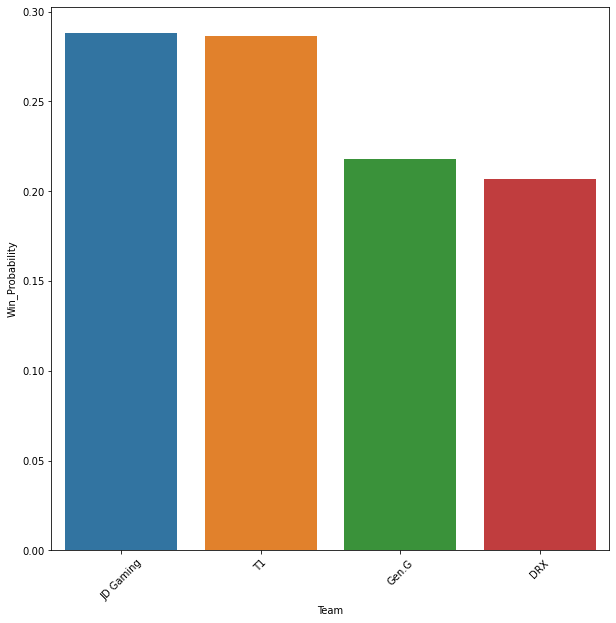

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(data=target_teams, x='Team', y='Win_Probability')
plt.xticks(rotation=45)